# **Single Cell RNA-Seq Analysis**

## NETLAB Demonstration Pipeline


#### Download the data

In [ ]:
%%time
# SPaRTAN scRNA-seq
!wget -q ftp://ftp.sra.ebi.ac.uk/vol1/fastq/SRR142/015/SRR14243915/SRR14243915_1.fastq.gz
!wget -q ftp://ftp.sra.ebi.ac.uk/vol1/fastq/SRR142/015/SRR14243915/SRR14243915_2.fastq.gz
!wget -q ftp://ftp.sra.ebi.ac.uk/vol1/fastq/SRR142/017/SRR14243917/SRR14243917_1.fastq.gz
!wget -q ftp://ftp.sra.ebi.ac.uk/vol1/fastq/SRR142/017/SRR14243917/SRR14243917_2.fastq.gz

CPU times: user 24 s, sys: 3.56 s, total: 27.6 s
Wall time: 1h 2min 18s


#### Install wrapper for the kallisto and bustools program,and the kb-python package

In [ ]:
%%time
!pip install --quiet kb-python

CPU times: user 320 ms, sys: 81.1 ms, total: 401 ms
Wall time: 16 s


#### Downloads a pre-built index and mapping file.

In [ ]:
%%time
!kb ref -d human -i index.idx -g t2g.txt

[2023-01-10 07:00:34,464]    INFO [download] Downloading files for human from https://caltech.box.com/shared/static/v1nm7lpnqz5syh8dyzdk2zs8bglncfib.gz to tmp/v1nm7lpnqz5syh8dyzdk2zs8bglncfib.gz
100% 2.23G/2.23G [03:05<00:00, 12.9MB/s]
[2023-01-10 07:03:39,499]    INFO [download] Extracting files from tmp/v1nm7lpnqz5syh8dyzdk2zs8bglncfib.gz
CPU times: user 3.1 s, sys: 419 ms, total: 3.52 s
Wall time: 3min 49s


#### Pseudoalign the reads, and then generate the cells x gene matrix in h5ad or loom format.

In [ ]:
%%time
!kb count -i /content/drive/MyDrive/scRNASeq/scRNASeq/index.idx -g /content/drive/MyDrive/scRNASeq/scRNASeq/t2g.txt -x 10xv3 --h5ad -t 2 -o /content/scRNASeq_counts1 \
/content/drive/MyDrive/scRNASeq/scRNASeq/SRR14243915_1.fastq.gz /content/drive/MyDrive/scRNASeq/scRNASeq/SRR14243915_2.fastq.gz

[2023-01-30 09:53:41,516]    INFO [count] Using index /content/drive/MyDrive/scRNASeq/scRNASeq/index.idx to generate BUS file to /content/scRNASeq_counts1 from
[2023-01-30 09:53:41,517]    INFO [count]         /content/drive/MyDrive/scRNASeq/scRNASeq/SRR14243915_1.fastq.gz
[2023-01-30 09:53:41,517]    INFO [count]         /content/drive/MyDrive/scRNASeq/scRNASeq/SRR14243915_2.fastq.gz
[2023-01-30 10:25:35,579]    INFO [count] Sorting BUS file /content/scRNASeq_counts1/output.bus to /content/scRNASeq_counts1/tmp/output.s.bus
[2023-01-30 10:25:51,972]    INFO [count] Whitelist not provided
[2023-01-30 10:25:51,972]    INFO [count] Copying pre-packaged 10XV3 whitelist to /content/scRNASeq_counts1
[2023-01-30 10:25:52,876]    INFO [count] Inspecting BUS file /content/scRNASeq_counts1/tmp/output.s.bus
[2023-01-30 10:26:01,256]    INFO [count] Correcting BUS records in /content/scRNASeq_counts1/tmp/output.s.bus to /content/scRNASeq_counts1/tmp/output.s.c.bus with whitelist /content/scRNASeq_

In [ ]:
%%time
!kb count -i /content/drive/MyDrive/scRNASeq/scRNASeq/index.idx -g /content/drive/MyDrive/scRNASeq/scRNASeq/t2g.txt --overwrite -x 10xv3 --h5ad -t 2 -o /content/scRNASeq_counts2 \
/content/drive/MyDrive/scRNASeq/scRNASeq/SRR14243917_1.fastq.gz /content/drive/MyDrive/scRNASeq/scRNASeq/SRR14243917_2.fastq.gz

In [ ]:
# List the available single cell technologies.
!kb --list

List of supported single-cell technologies

Positions syntax: `input file index, start position, end position`
When start & end positions are None, refers to the entire file
Custom technologies may be defined by providing a kallisto-supported technology string
(see https://pachterlab.github.io/kallisto/manual)

name            description                            whitelist    barcode                    umi        cDNA                       
------------    -----------------------------------    ---------    -----------------------    -------    -----------------------    
10XV1           10x version 1                          yes          0,0,14                     1,0,10     2,None,None                
10XV2           10x version 2                          yes          0,0,16                     0,16,26    1,None,None                
10XV3           10x version 3                          yes          0,0,16                     0,16,28    1,None,None                
10XV3_ULTIMA    1

# Post-process

In [ ]:
!pip install --quiet scanpy==1.9.1
!pip install --quiet matplotlib==3.5.2
# Import packages
import anndata
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
sc.settings.verbosity = 3
sc.settings.set_figure_params(dpi=100, facecolor="white")

# Create an anndata object

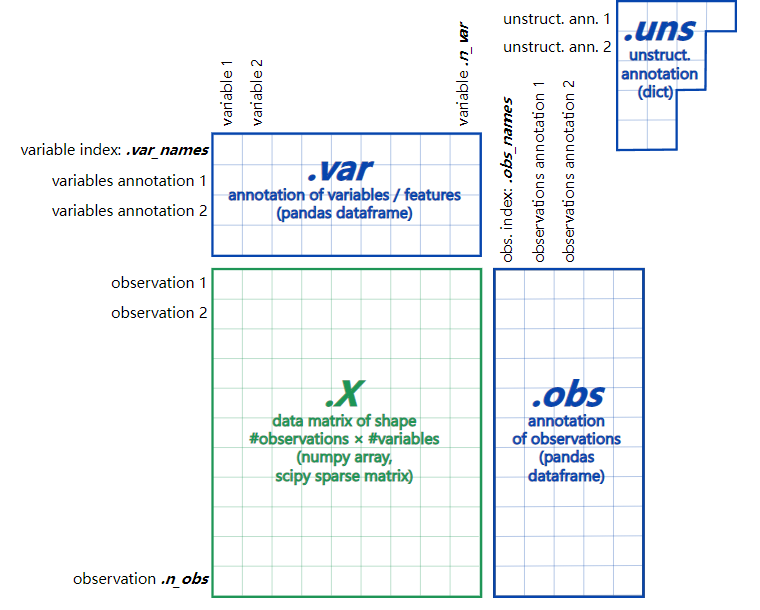

In [ ]:
# create ann data object
adata = anndata.read_h5ad('/content/drive/MyDrive/scRNASeq/scRNASeq/scRNASeq_counts1/counts_unfiltered/adata.h5ad')
adata

AnnData object with n_obs × n_vars = 64168 × 60623
    var: 'gene_name'

# Annotations

### Adding Gene Symbols

In [ ]:
%%time
t2g = pd.read_csv("/content/drive/MyDrive/scRNASeq/scRNASeq/t2g.txt",  delimiter="\t", header=None, usecols=[1,2], index_col=0, dtype=str)
my_genes = pd.read_csv("/content/drive/MyDrive/scRNASeq/scRNASeq/scRNASeq_counts1/counts_unfiltered/cells_x_genes.genes.txt",delimiter="\t", header=None, dtype=str)
my_genes = list(my_genes[0])
t2g = t2g.squeeze()
t2g.drop_duplicates(inplace=True)
indexes = list(t2g.index)
adata.var["gene_symbols"] = np.array([t2g[gene] if gene in indexes else gene for gene in my_genes])

CPU times: user 39.6 s, sys: 26.4 ms, total: 39.6 s
Wall time: 42.5 s


In [ ]:
adata.var_keys

<bound method AnnData.var_keys of AnnData object with n_obs × n_vars = 64168 × 60623
    var: 'gene_name', 'gene_symbols'>

### Mitochondirial genes

In [ ]:
adata.var["mt"] = adata.var["gene_symbols"].str.startswith("MT-")
adata.var_keys

<bound method AnnData.var_keys of AnnData object with n_obs × n_vars = 64168 × 60623
    var: 'gene_name', 'gene_symbols', 'mt'>

### Total counts per barcode

In [ ]:
total = np.array(np.sum(adata.X, axis=1)).squeeze()
adata.obs["total_counts"] = total
adata.obs_keys

<bound method AnnData.obs_keys of AnnData object with n_obs × n_vars = 64168 × 60623
    obs: 'total_counts'
    var: 'gene_name', 'gene_symbols', 'mt'>

### Number of genes by counts




In [ ]:
%%time
n_genes_by_counts = np.array([np.count_nonzero(array.toarray(), axis = 1) for array in adata.X]).squeeze()
adata.obs["n_genes_by_counts"] = n_genes_by_counts
adata.obs_keys

CPU times: user 10.4 s, sys: 0 ns, total: 10.4 s
Wall time: 10.6 s


<bound method AnnData.obs_keys of AnnData object with n_obs × n_vars = 64168 × 60623
    obs: 'total_counts', 'n_genes_by_counts'
    var: 'gene_name', 'gene_symbols', 'mt'>

### Percent mitochondrial counts


In [ ]:
mt_index = np.array(adata.var["mt"], dtype=bool)
mt_total = np.array([np.sum(array.toarray().squeeze()[mt_index]) for array in adata.X])
adata.obs["pct_counts_mt"] = 100 * mt_total / adata.obs["total_counts"]

# Plot the Metrics

In [ ]:
# !pip install --quiet matplotlib==3.1.3

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 39.8 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
scanpy 1.9.1 requires matplotlib>=3.4, but you have matplotlib 3.1.3 which is incompatible.


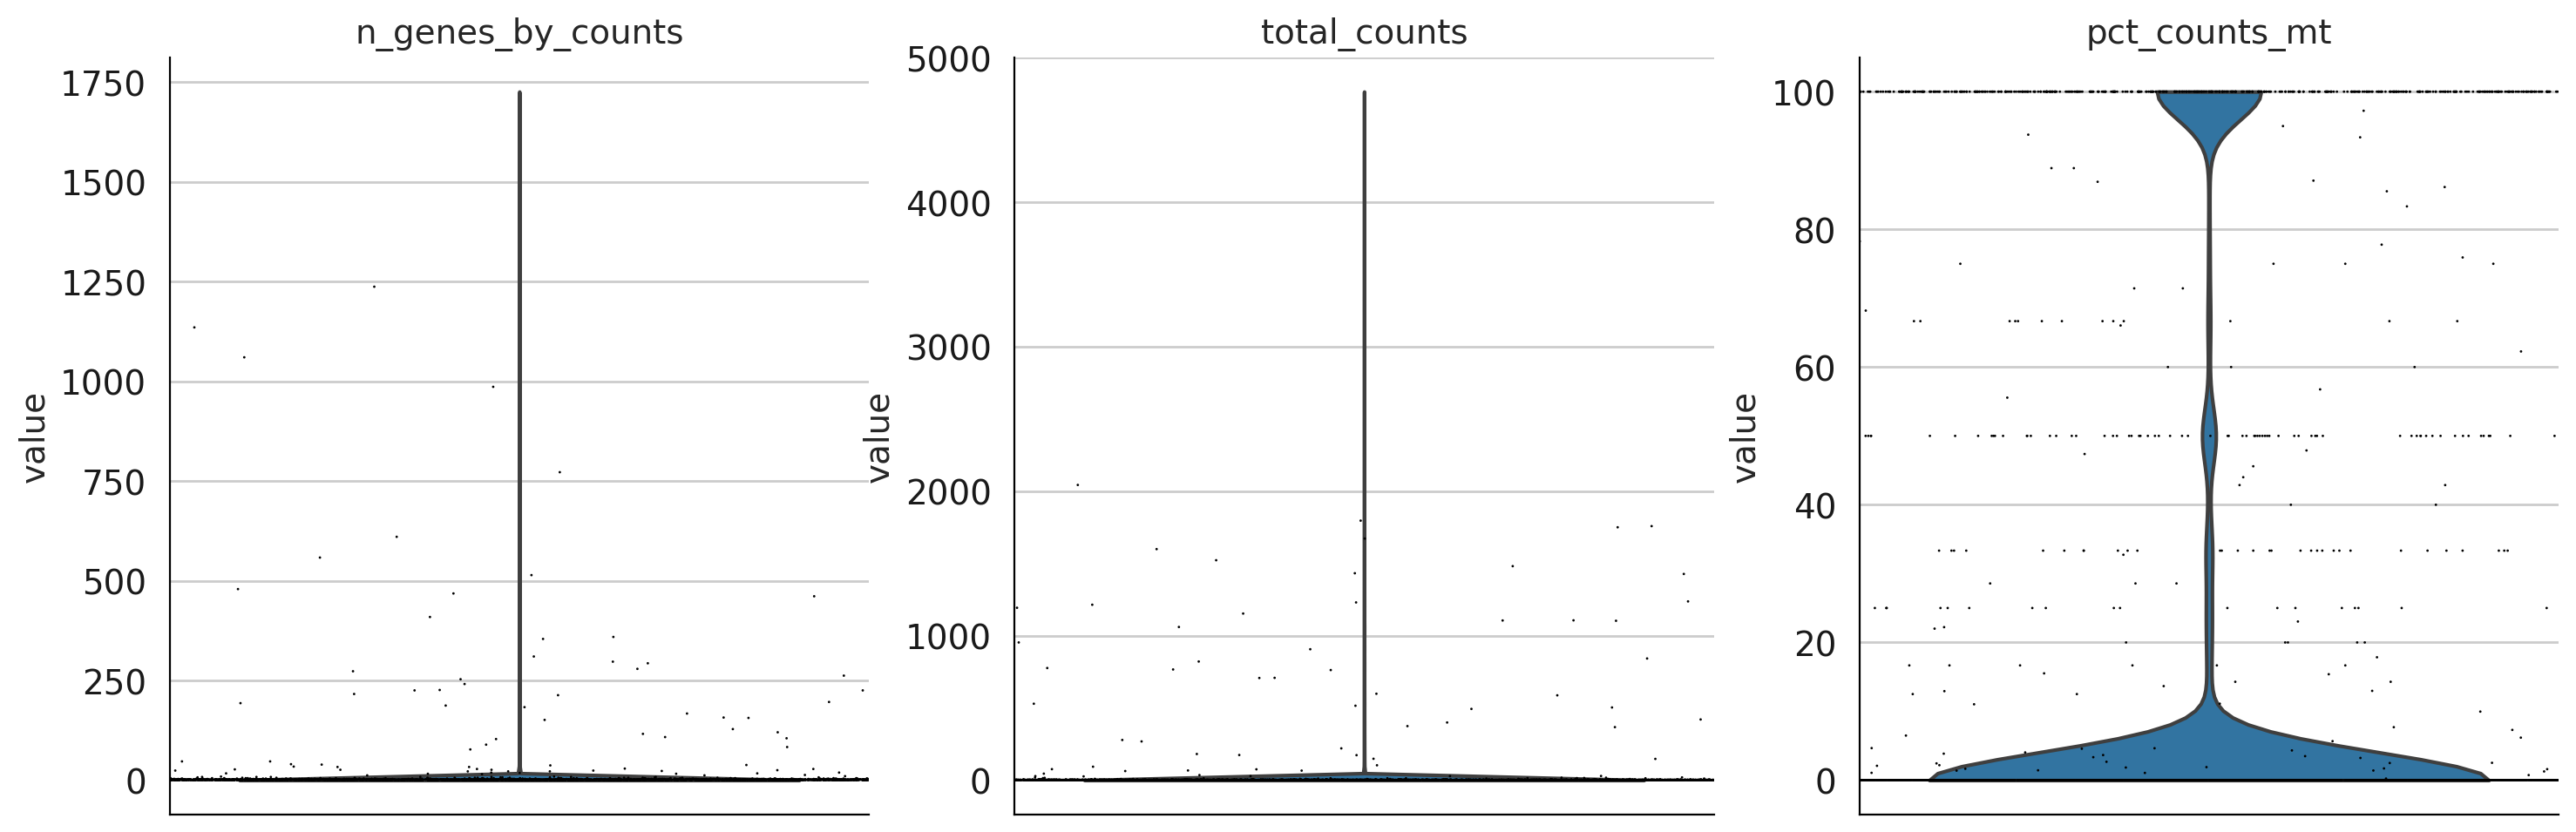

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


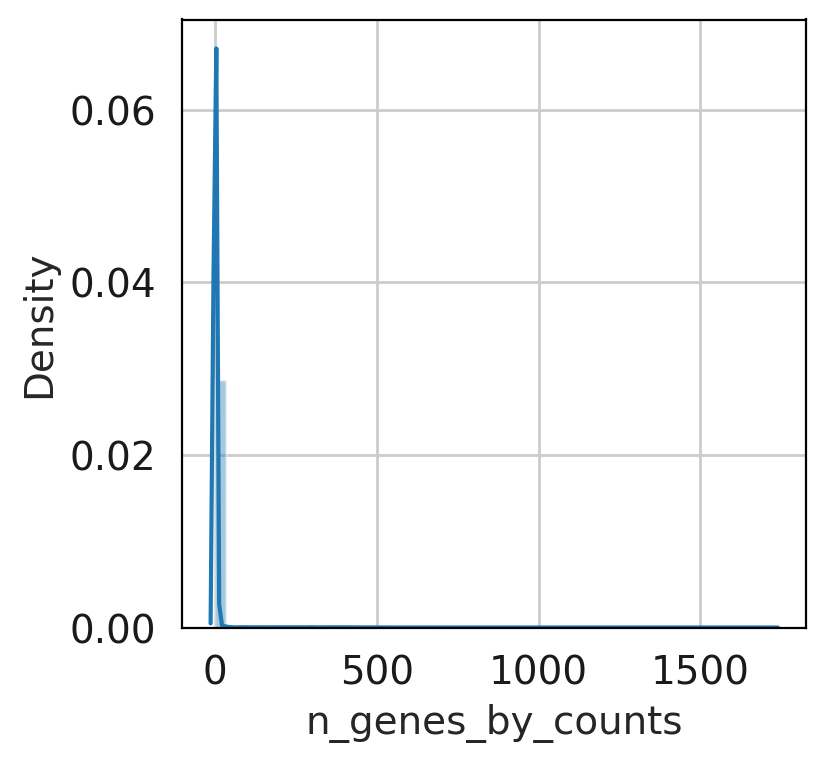

In [ ]:
sc.pl.violin(adata, ["n_genes_by_counts", "total_counts", "pct_counts_mt"], jitter=8.4, multi_panel=True)
sns.distplot(adata.obs["n_genes_by_counts"])

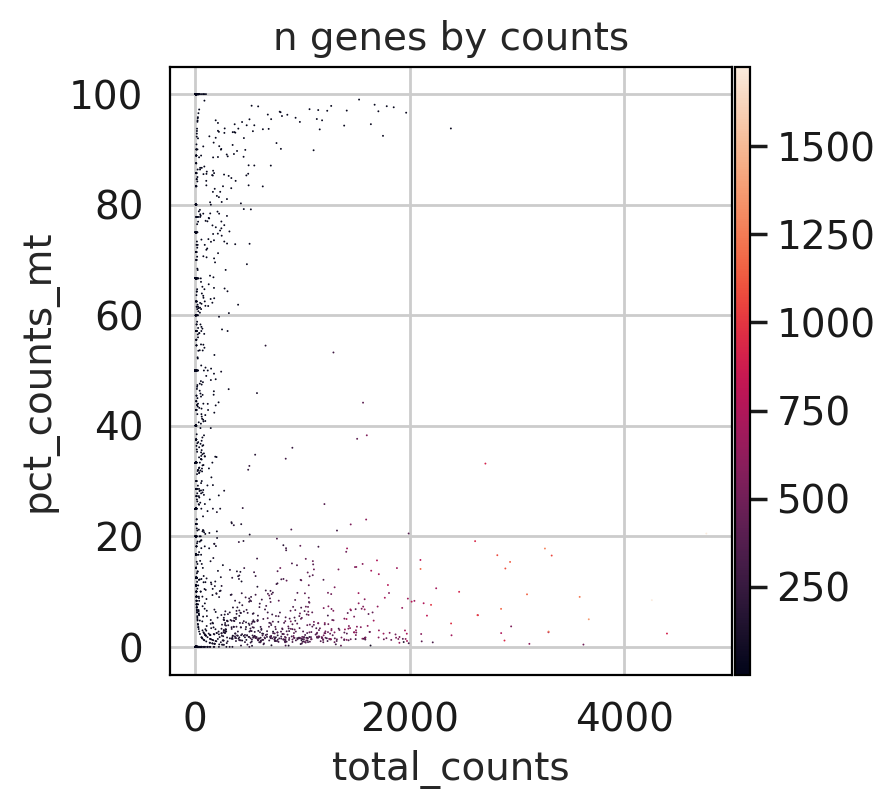

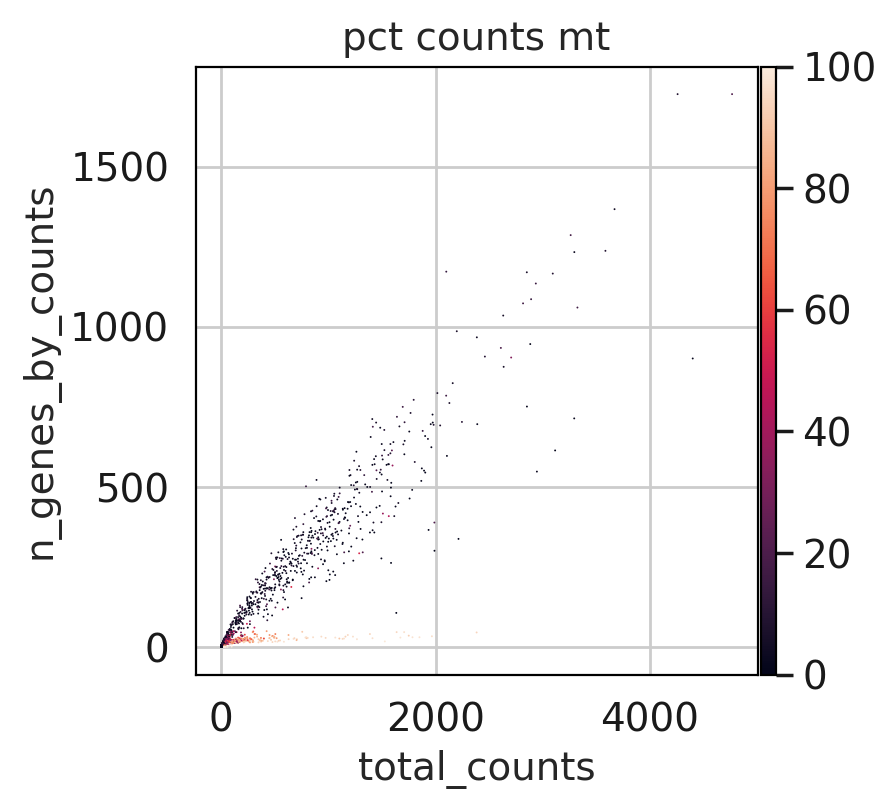

In [ ]:
# Scatter Plot of QC metrics
sc.pl.scatter(adata, x = "total_counts", y="pct_counts_mt", color = "n_genes_by_counts")
sc.pl.scatter(adata, x = "total_counts", y="n_genes_by_counts", color = "pct_counts_mt")

# Exploratory Analysis

normalizing counts per cell
    finished (0:00:00)


/usr/local/lib/python3.8/dist-packages/scanpy/preprocessing/_normalization.py:197: UserWarning: Some cells have zero counts
  warn(UserWarning('Some cells have zero counts'))


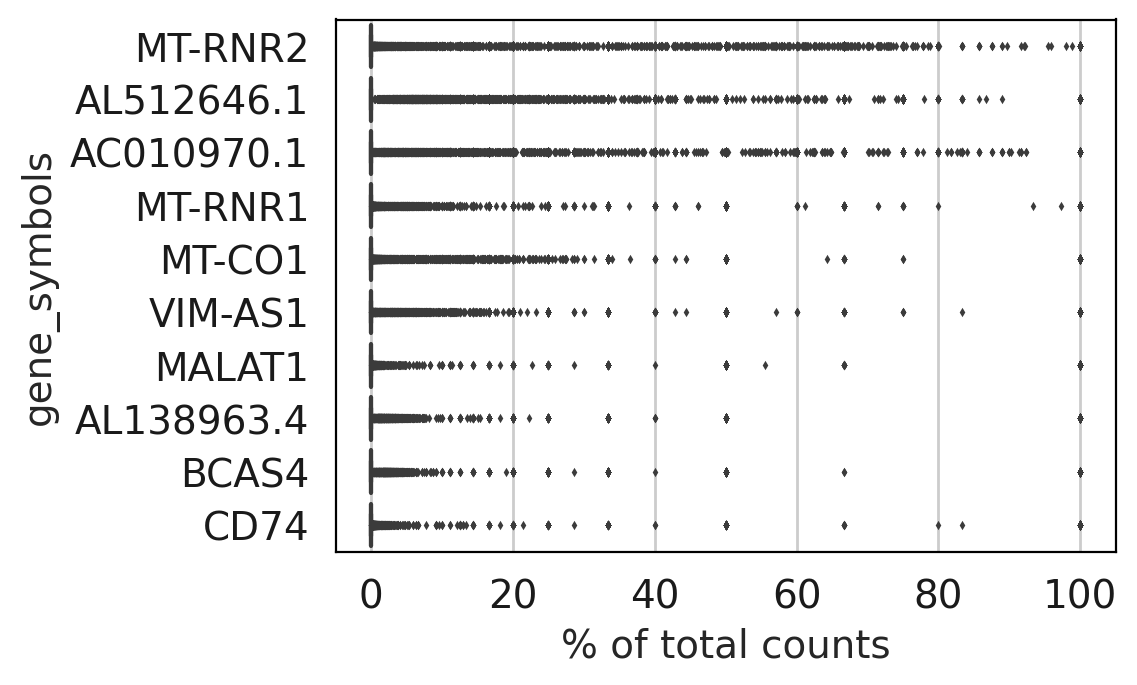

In [ ]:
# Finds genes that has highest count in the data
sc.pl.highest_expr_genes(adata, gene_symbols = "gene_symbols", n_top=10)

filtered out 63565 cells that have less than 100 genes expressed
filtered out 49101 genes that are detected in less than 3 cells
(459, 11522)


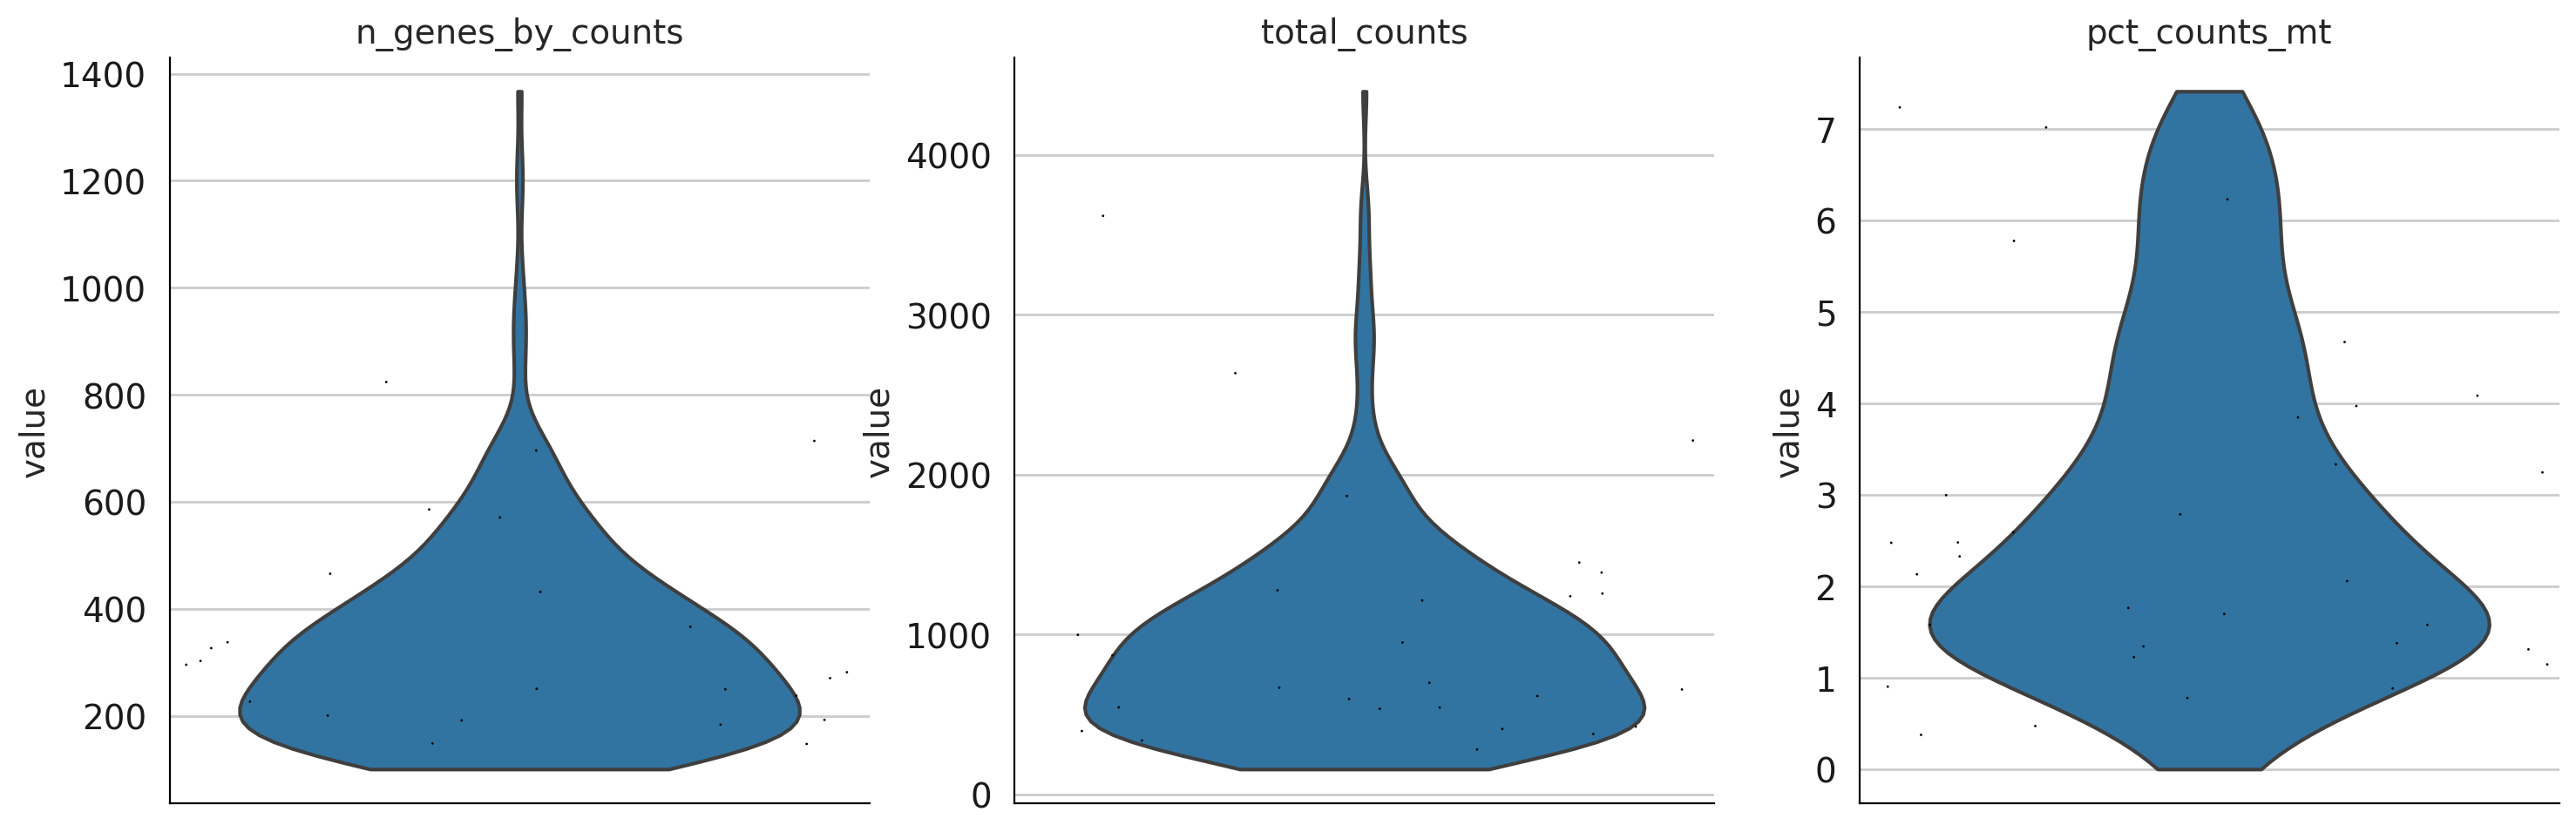

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


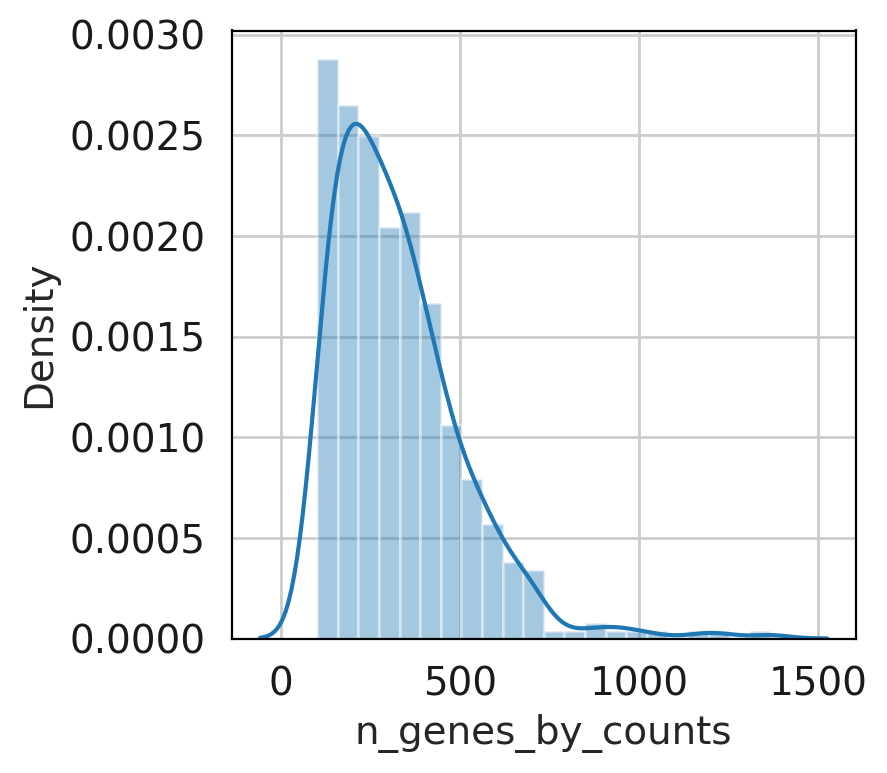

In [ ]:
# Basic Filtering (These are inplace!!!)
QC_data = adata.copy() # To keep original adata, make a copy for Quality Control
sc.pp.filter_cells(QC_data, min_genes=100) # Filter barcodes that have less than 100 genes determined
sc.pp.filter_genes(QC_data, min_cells=3) # Filter genes that are found in less than 3 cells
sc.pp.filter_cells(QC_data, max_counts=50000) # Filter cells that have more than 50,000 total counts

# Filter by slicing
QC_data = QC_data[QC_data.obs.n_genes_by_counts < 1800,:] # Select number of genes detected less than 1800
QC_data = QC_data[QC_data.obs.pct_counts_mt < 7.5,:] # Select mitochondrial gene percent is less than 7.5%

# Check new number of cells and genes remained.
print(QC_data.X.shape)
sc.pl.violin(QC_data, ["n_genes_by_counts", "total_counts", "pct_counts_mt"], jitter=8.4, multi_panel=True)
# Histogram of QC metrics
sns.distplot(QC_data.obs["n_genes_by_counts"])

normalizing counts per cell
    finished (0:00:00)


/usr/local/lib/python3.8/dist-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


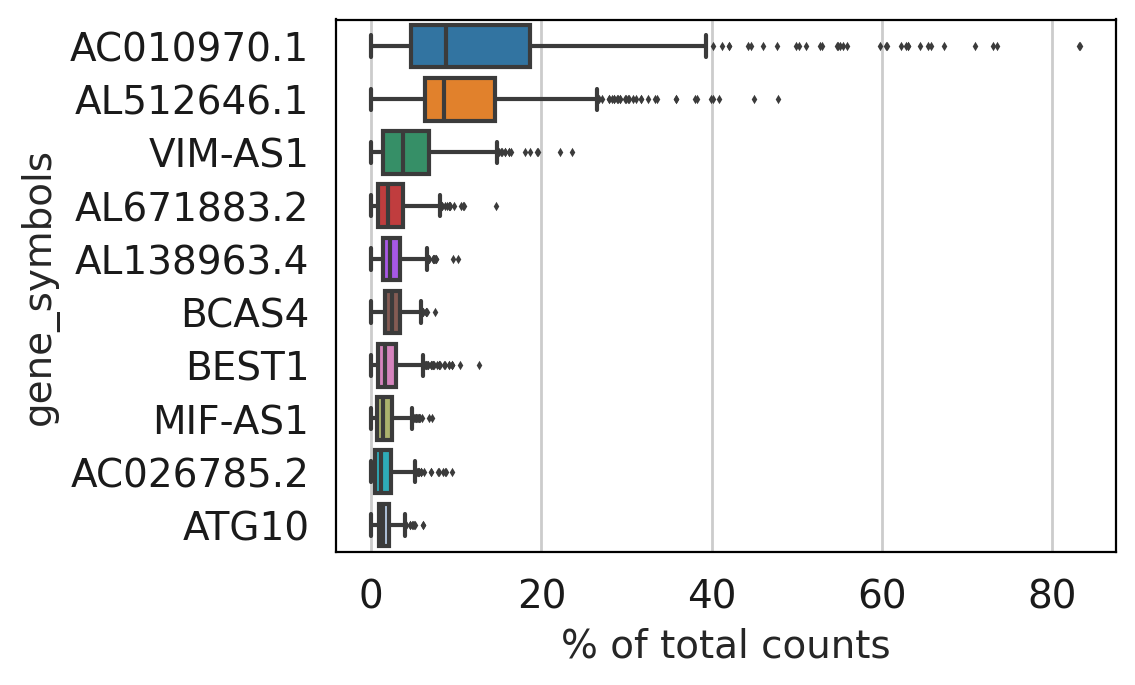

In [ ]:
sc.pl.highest_expr_genes(QC_data, gene_symbols = "gene_symbols", n_top=10)

# Normalization, Dimensionality Reduction, Determining HVGs


In [ ]:
from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors import DistanceMetric
from sklearn.decomposition import PCA

normalizing counts per cell
    finished (0:00:00)
extracting highly variable genes
    finished (0:00:12)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


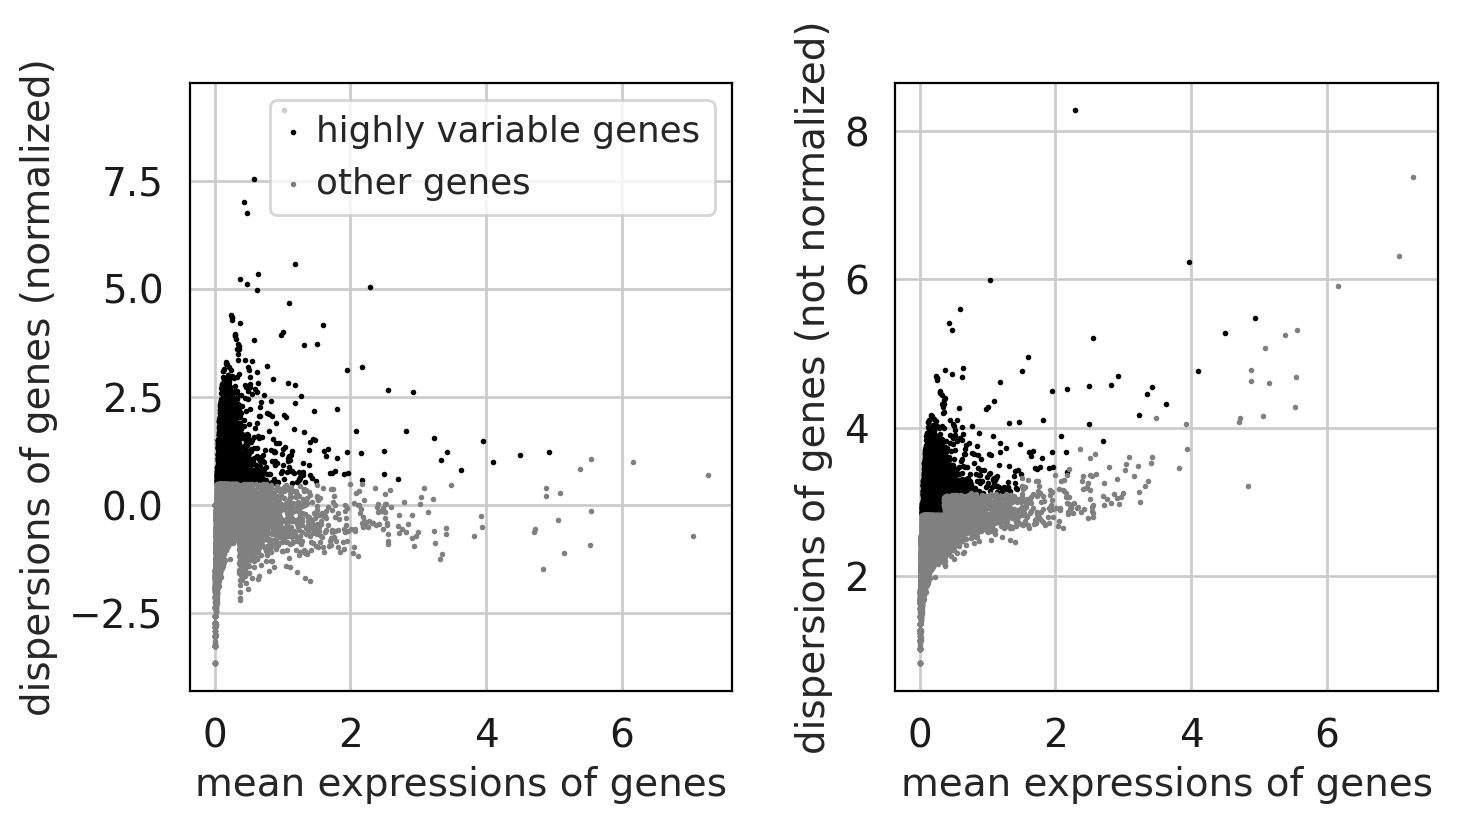

In [ ]:
# Normalize counts to 10,000 count per celll
norm_data = QC_data.copy() # Again make a copy of QC for normalized data
sc.pp.normalize_total(norm_data, target_sum= 10000)

# log(x+1) transform
sc.pp.log1p(norm_data)

# Identify highly variable genes
# min_mean excludes zero counts which has zero means.
# max_mean excludes too variable genes which may amplified etc.
sc.pp.highly_variable_genes(norm_data, min_mean=0.0125, max_mean = 5, inplace=True)

# Plot dispersion vs expression
sc.pl.highly_variable_genes(norm_data)

In [ ]:
norm_data

AnnData object with n_obs × n_vars = 459 × 11522
    obs: 'total_counts', 'n_genes_by_counts', 'pct_counts_mt', 'n_genes', 'n_counts'
    var: 'gene_name', 'gene_symbols', 'mt', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg'

... as `zero_center=True`, sparse input is densified and may lead to large memory consumption
computing PCA
    on highly variable genes
    with n_comps=100
    finished (0:00:00)


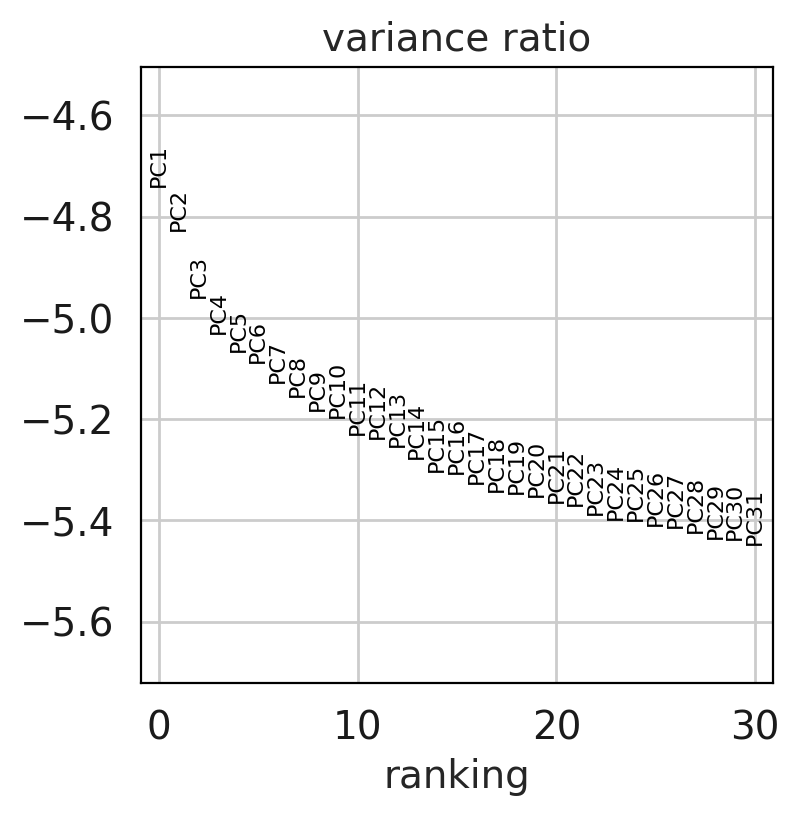

In [ ]:
# Again make a copy for HVGs to keep normalized data
HVG_data = norm_data.copy() 

# Filter to only include HVGs
HVG_data.raw = HVG_data
HVG_data = HVG_data[:, HVG_data.var.highly_variable]
pc_HVG_data = HVG_data.copy()

# Scale to unit variance for PCA, clip values exceeding var 10
sc.pp.scale(pc_HVG_data, max_value = 10)

# Reduce the dimensionality of the data by PCA
# n_comps is number of principal comp.(dimensions) we want to analyze
sc.pp.pca(pc_HVG_data, svd_solver = "arpack", n_comps = 100)
# Plot contribution of each gene to PCA
sc.pl.pca_variance_ratio(pc_HVG_data, log=True, n_pcs=30)

In [ ]:
HVG_data

View of AnnData object with n_obs × n_vars = 459 × 3229
    obs: 'total_counts', 'n_genes_by_counts', 'pct_counts_mt', 'n_genes', 'n_counts'
    var: 'gene_name', 'gene_symbols', 'mt', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg'

In [ ]:
pc_HVG_data

AnnData object with n_obs × n_vars = 459 × 3229
    obs: 'total_counts', 'n_genes_by_counts', 'pct_counts_mt', 'n_genes', 'n_counts'
    var: 'gene_name', 'gene_symbols', 'mt', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

computing neighbors
    using 'X_pca' with n_pcs = 6
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing tSNE
    using 'X_pca' with n_pcs = 6
    using sklearn.manifold.TSNE


/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


    finished: added
    'X_tsne', tSNE coordinates (adata.obsm) (0:00:03)


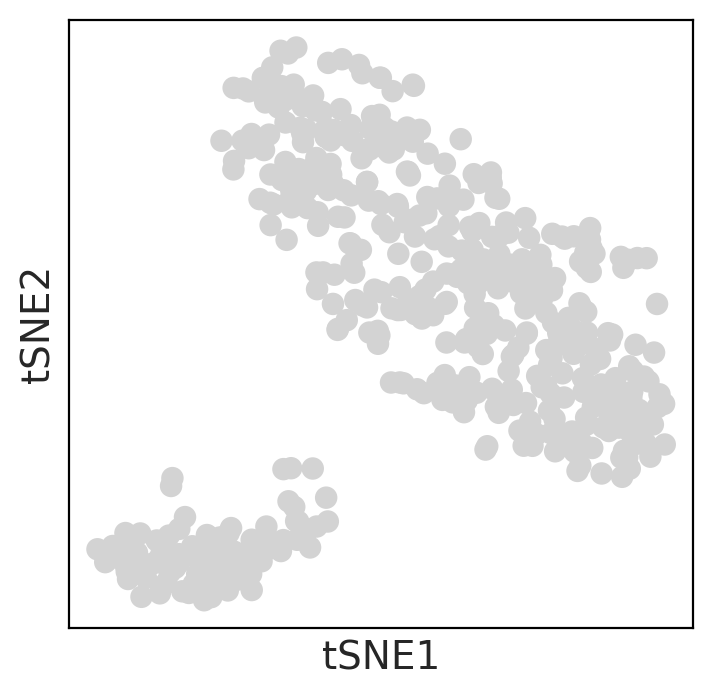

In [ ]:
# Computing the neighborhood graph
sc.pp.neighbors(pc_HVG_data, n_pcs = 6)
# Visualize data with t-SNE (Selected from contribution of each gene to PCA plot)
sc.tl.tsne(pc_HVG_data, n_pcs=6)
sc.pl.tsne(pc_HVG_data)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:02)


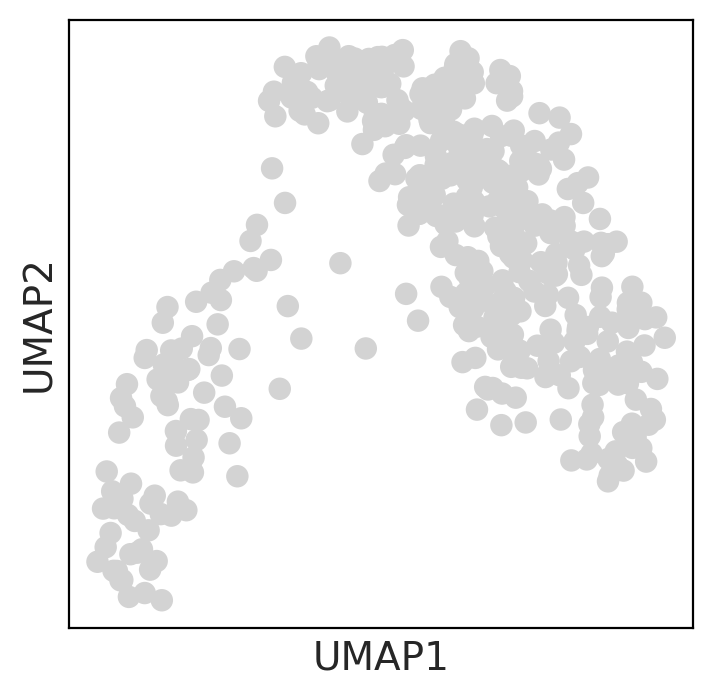

In [ ]:
# Visualize data with UMAP (Selected from contribution of each gene to PCA plot)
sc.tl.umap(pc_HVG_data, n_components = 6)
sc.pl.umap(pc_HVG_data)

# Downstream Analysis

## Marker Genes

In [ ]:
all = []
for PC in range(2):
  lows = set(np.array(pc_HVG_data.var.index)[pc_HVG_data.varm["PCs"][:,PC].argsort()][0:5])
  highs = set(np.array(pc_HVG_data.var.index)[pc_HVG_data.varm["PCs"][:,PC].argsort()][-5:])
  all += list(lows)
  all += list(highs)

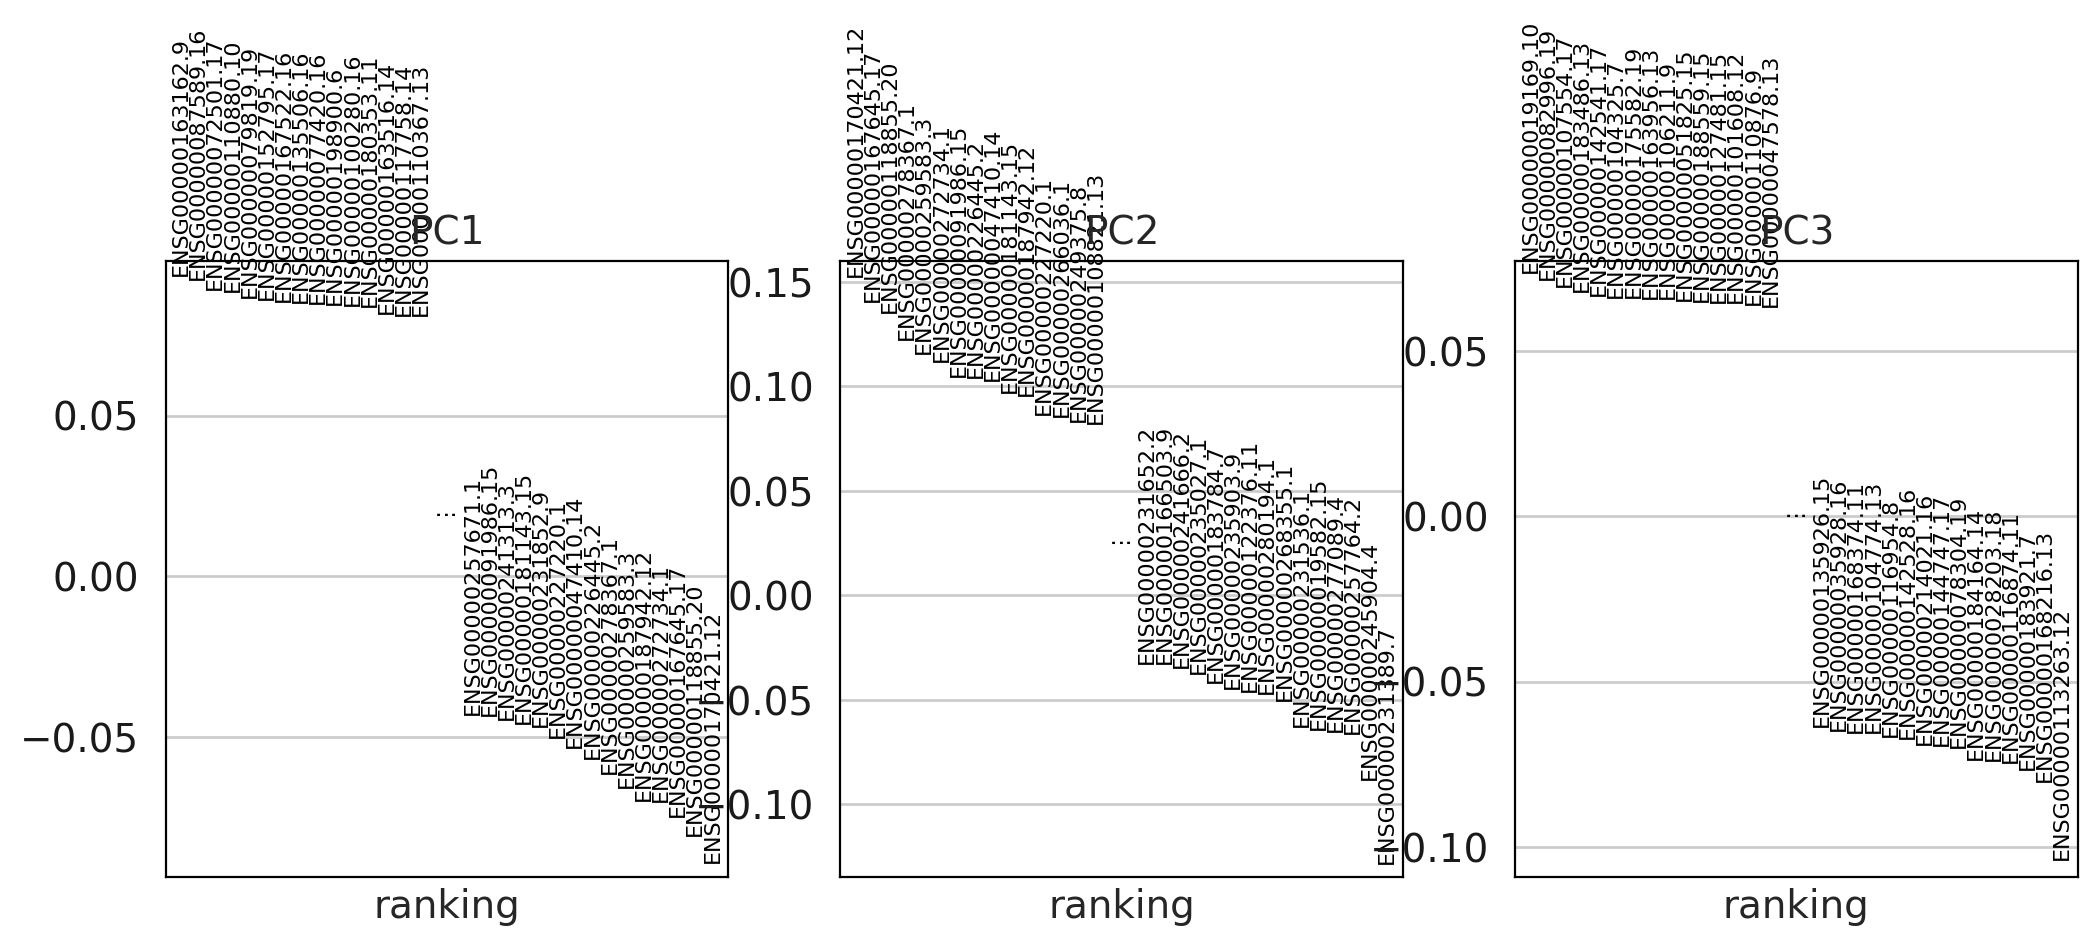

In [ ]:
sc.pl.pca_loadings(pc_HVG_data)

In [ ]:
sc.pl.tsne(pc_HVG_data, color=all, gene_symbols="gene_symbols")

In [ ]:
!pip install --quiet leidenalg

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 17.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 51.5 MB/s eta 0:00:00


running Leiden clustering
    finished: found 2 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


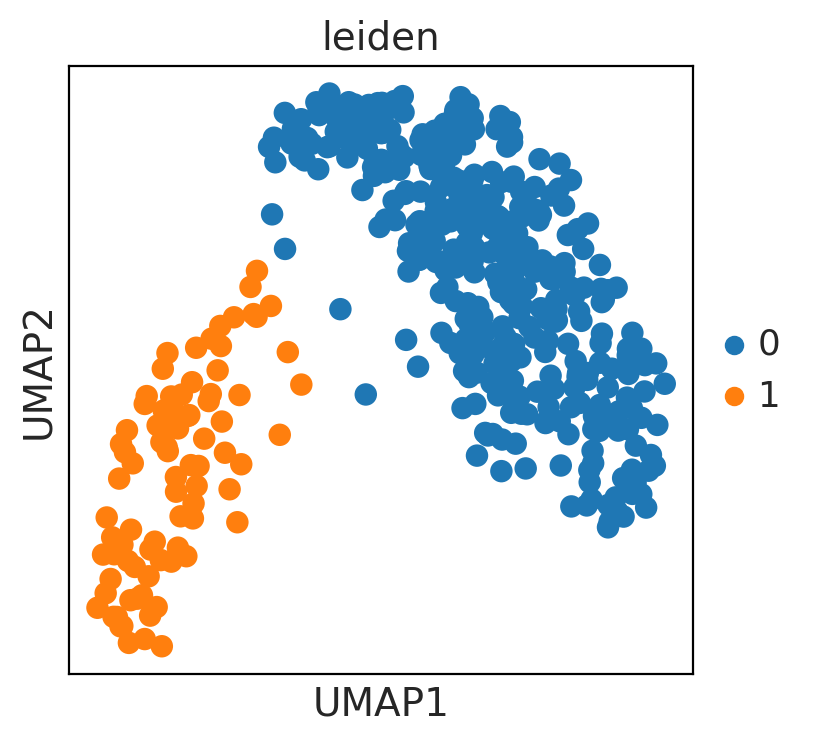

In [ ]:
sc.tl.leiden(pc_HVG_data, resolution=0.1)
sc.pl.umap(pc_HVG_data, color=["leiden"])

In [ ]:
gene_symbols = []
for gene in all:
  gene_symbols.append(pc_HVG_data.var["gene_symbols"][pc_HVG_data.var_names==gene][0])
print(gene_symbols)

['YIF1B', 'KRT8', 'MFSD1', 'ADIRF-AS1', 'LDLRAD2', 'EPB41L2', 'SMC1A', 'CASS4', 'RNF149', 'CORO1C', 'AC243829.4', 'AC020656.1', 'CD74', 'AC025164.1', 'HLA-DPA1', 'YIF1B', 'KRT8', 'MFSD1', 'AL356652.1', 'AC015712.2']


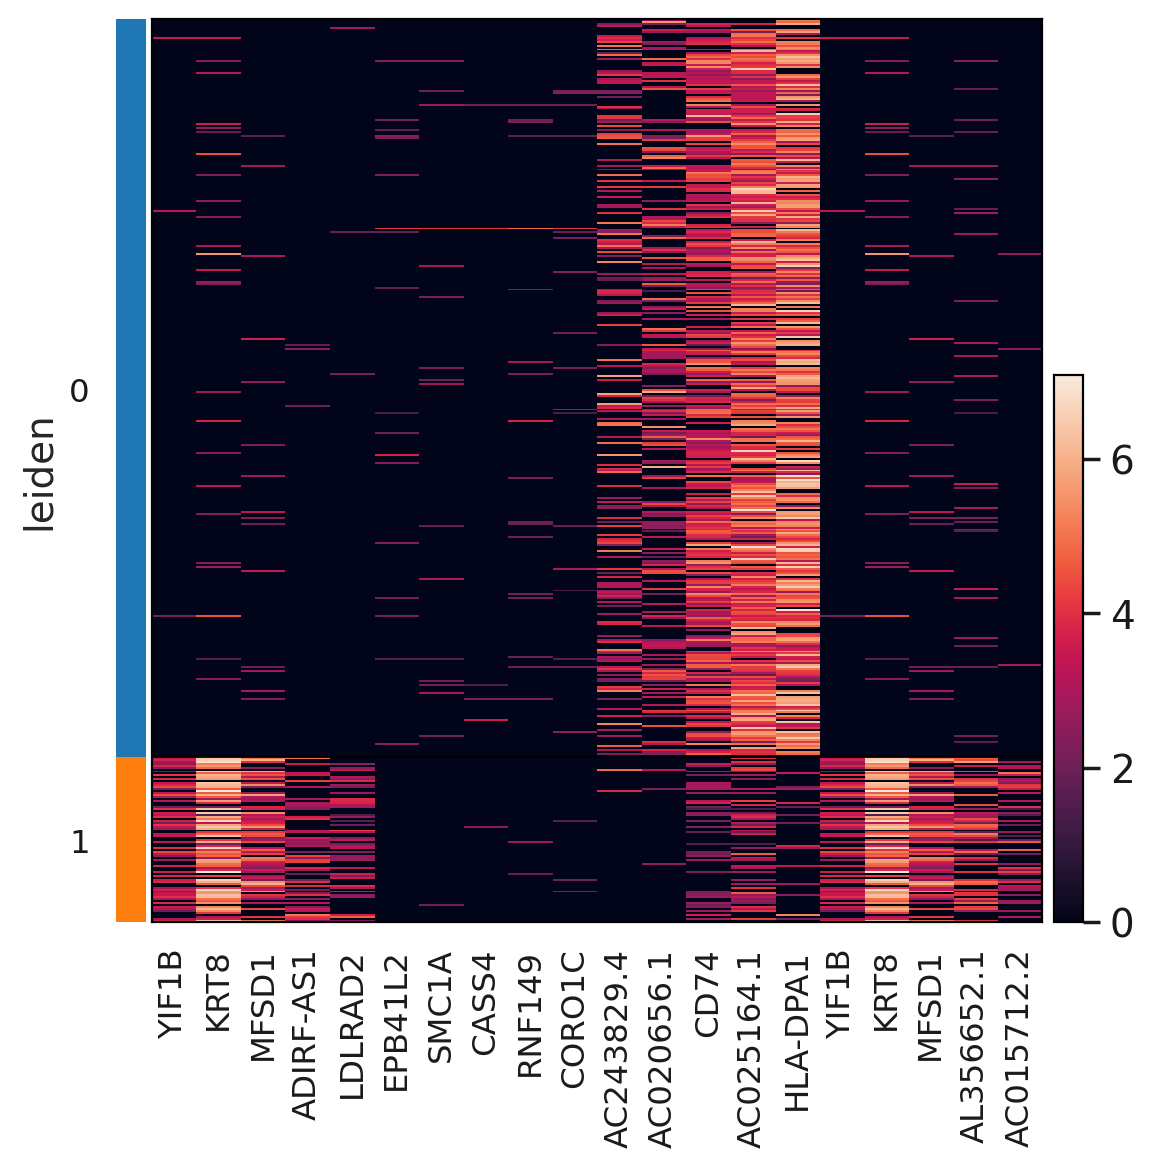

In [ ]:
sc.pl.heatmap(pc_HVG_data, var_names = gene_symbols, groupby="leiden", gene_symbols="gene_symbols")

In [ ]:
pc_HVG_data

AnnData object with n_obs × n_vars = 459 × 3229
    obs: 'total_counts', 'n_genes_by_counts', 'pct_counts_mt', 'n_genes', 'n_counts', 'leiden'
    var: 'gene_name', 'gene_symbols', 'mt', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'tsne', 'umap', 'leiden', 'leiden_colors'
    obsm: 'X_pca', 'X_tsne', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'